<a href="https://colab.research.google.com/github/k00lk0der1/synthpoppp/blob/main/SDV_Height_Weight_HR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sdv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# working_dir = '/content/drive/MyDrive/PhD_Data/Synth_Pop/Analysis/Source_Files/District_wise_source_files/'

In [ ]:
%cd /content/drive/MyDrive/PhD_Data/Synth_Pop/Analysis/Source_Files/District_wise_source_files/

/content/drive/.shortcut-targets-by-id/1YEhqsUhJ6rY4G5EtW4OZIIzbBRUKnxtm/synthetic


In [ ]:
!ls

36151-0001-Data.tsv			      Faridabad
36151-0002-Data.tsv			      Final_619_15_05_22.csv
6_19_CopulaGAN_15_05_2022.pkl		      haryana
6_19_CTGAN_15_05_2022.pkl		      haryana_old
619_HR_FARIDABAD_12_05_22.pkl		      HR_IHDS_Age_Gender_Count.csv
619_HR_FARIDABAD.pkl			      IPU_Age_Gender_Req.csv
619_HR_FARIDABAD_tabular_preset_13_05_22.pkl  mumbai
619_HR_FARIDABAD_tabular_preset_15_05_22.pkl  preset_4_Age_Gender_Count.csv
6_19_TVAE_15_05_2022.pkl		      query_dist.py
d_code.xls				      Sample_Final_619_15_05_22.csv
Distt_SHP.zip				      synth_619_preset.csv


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm, trange

In [ ]:
from sdv.tabular import GaussianCopula
from sdv.tabular import CTGAN
from sdv.tabular import CopulaGAN
from sdv.tabular import TVAE

from sdv.lite import TabularPreset

In [ ]:
region_name = "Faridabad"
state_id = 6 ####### select state number and name appropriately. Check d_code.xls for state and distrcit codes
district_ids = [19] #Faridabad District

In [ ]:
# ipu_synthpop = pd.read_csv('./Faridabad/synthetic_state_wise.csv')

ipu_synthpop = pd.read_csv('./haryana/ambala/synthetic_state_wise.csv')
# Takes around 7 seconds for a while of around 1.8 million rows

In [ ]:
ipu_synthpop.sort_values(by=['Age', 'SexLabel'], inplace=True)
# From this point onwards, the ipu_synthpop is sorted by ['Age','SexLabel']

In [ ]:
ipu_synthpop_age_sexlabel_req = ipu_synthpop.groupby( [ "Age", "SexLabel"] ).size().to_frame(name = 'count').reset_index()
# ipu_synthpop_age_sexlabel_req.to_csv("IPU_Age_Gender_Req.csv")

In [ ]:
ipu_synthpop_age_sexlabel_req = ipu_synthpop_age_sexlabel_req.reset_index()  # make sure indexes pair with number of rows

# Make a df for the state by filtering IHDS data

In [ ]:
ihds_individuals_data = pd.read_csv("36151-0001-Data.tsv",sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,6,9,10,11,12,13,14,15,16,17,18,22,27,29,33,34,39,44,48,49,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,74,75,76,78,79,80,88,91,105,150,151,152,154,158,159,166,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,194,196,197,198,199,200,201,202,203,204,205,217,218,219,220,221,222,223,224,225,226,227,228,229,230,234,235,236,237,240,241,243,245,247,248,249,250,275,279,283,287,288,289,290,291,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,320,322,334) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
filtered_ihds_individuals_data = ihds_individuals_data.loc[ihds_individuals_data.STATEID==state_id]

In [ ]:
columns_to_keep_individuals = ['DISTRICT', 'IDHH', 'PERSONID', 'AP5', 'AP8', 'RO3', 'RO6', 'RO5','ED2', 'ID11', 'ID13', 'RO7', 'URBAN2011',
                               'MB3','MB4','MB5','MB6','MB7','MB8','MB9','MB10','MB11','MB12','MB13',
								'SM4','SM5','SM7']
columns_rename_dict_individuals = {'AP5':'Height', 'AP8' :'Weight','RO3':'SexLabel', 'RO5':'Age', 'RO6':'marital_status',
			'ED2':'literacy', 'ED6':'edu_years', 'EDUC7': 'edu_cat',
			'ID11':'religion', 'ID13':'caste', 'URBAN2011':'residence',
			'WS4':'job', 'RO7':'activity_status', 'IDHH':'serialno', 'PERSONID':'mem_id',
			'DIST01':'district', 'MB3':'M_Cataract', 'MB4':'M_TB', 'MB5':'M_High_BP',
			'MB6':'M_Heart_disease', 'MB7':'M_Diabetes', 'MB8':'M_Leprosy',
			'MB9':'M_Cancer', 'MB10':'M_Asthma', 'MB11':'M_Polio',
			'MB12':'M_Paralysis', 'MB13':'M_Epilepsy', 
			'SM4':'M_Fever', 'SM5':'M_Cough','SM7':'M_Diarrhea'}

In [ ]:
filtered_ihds_individuals_data = filtered_ihds_individuals_data[columns_to_keep_individuals]
filtered_ihds_individuals_data = filtered_ihds_individuals_data.rename(columns_rename_dict_individuals, axis='columns')

In [ ]:
hr_ihds = filtered_ihds_individuals_data[['Age','SexLabel','Height','Weight',
                                          'M_Cataract','M_TB','M_High_BP',
                                          'M_Heart_disease', 'M_Diabetes', 
                                          'M_Leprosy', 'M_Cancer', 'M_Asthma',
                                          'M_Polio', 'M_Paralysis', 'M_Epilepsy', 
                                          'M_Fever', 'M_Cough','M_Diarrhea']]

In [ ]:
# hr_ihds.dropna(inplace=True)

# Drop NA on HR IHDS does not drop any rows

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
cols = hr_ihds.columns.drop('SexLabel')

In [ ]:
hr_ihds[cols] = hr_ihds[cols].apply(pd.to_numeric, errors='coerce')

# Source: https://stackoverflow.com/a/36814203/6603215 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
hr_ihds['SexLabel'] = hr_ihds['SexLabel'].map({1:'Male', '1':'Male', 2:'Female', '2':'Female'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Constraints for SDV model

Don't need the following constraints as they are redundant for Between constraint

In [ ]:
# from sdv.constraints import Positive

# positive_age_constraint = Positive(
#     columns = 'Age',
#     strict=False,
#     handling_strategy='reject_sampling'
# )

# positive_weight_constraint = Positive(
#     columns = 'Weight',
#     strict=False,
#     handling_strategy='reject_sampling'
# )

# positive_height_constraint = Positive(
#     columns = 'Height',
#     strict=False,
#     handling_strategy='reject_sampling'
# )

In [ ]:
from sdv.constraints import Between

reasonable_age_constraint = Between(
    column='Age',
    low=0,
    high=100,
    handling_strategy='transform'
)

reasonable_height_constraint = Between(
    column='Height',
    low=0,
    high=220,
    handling_strategy='transform'
)

reasonable_weight_constraint = Between(
    column='Weight',
    low=0,
    high=200,
    handling_strategy='transform'
)

In [ ]:
from sdv.constraints import Rounding

age_rounding_constraint = Rounding(columns='Age',
                                       digits=0,
                                       handling_strategy='transform'
                                      )

height_rounding_constraint = Rounding(columns='Height',
                                       digits=1,
                                       handling_strategy='transform'
                                      )

weight_rounding_constraint = Rounding(columns="Weight",
                                       digits=2,
                                       handling_strategy='transform'
                                      )

In [ ]:
constraints = [
            #    positive_age_constraint,
            #    positive_weight_constraint,
            #    positive_height_constraint,
               reasonable_age_constraint,
               reasonable_height_constraint,
               reasonable_weight_constraint,
            #    age_rounding_constraint,
            #    height_rounding_constraint,
            #    weight_rounding_constraint
              ]

# Source: https://sdv.dev/SDV/user_guides/single_table/handling_constraints.html 

In [ ]:


!ls -al /usr/share/zoneinfo/Asia/Kolkata

lrwxrwxrwx 1 root root 8 Mar 21 20:52 /usr/share/zoneinfo/Asia/Kolkata -> Calcutta


In [ ]:
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Kolkata /etc/localtime 
!date

rm: cannot remove '/etc/localtime': No such file or directory
Mon May 16 01:35:33 IST 2022


In [ ]:
!ls -ltr

total 1736849
-rw------- 1 root root 174228223 Mar 31  2021 36151-0001-Data.tsv
-rw------- 1 root root  79469743 Apr  2  2021 36151-0002-Data.tsv
drwx------ 2 root root      4096 Mar 23 22:56 mumbai
drwx------ 2 root root      4096 Apr  5 16:23 Faridabad
-rw------- 1 root root   7134188 Apr  6 12:51 Distt_SHP.zip
-rw------- 1 root root       377 Apr 14 17:21 query_dist.py
-rw------- 1 root root     82944 Apr 14 17:29 d_code.xls
drwx------ 2 root root      4096 May  9 19:39 haryana_old
drwx------ 2 root root      4096 May  9 19:39 haryana
-rw------- 1 root root    216415 May 12 17:16 619_HR_FARIDABAD.pkl
-rw------- 1 root root    216415 May 12 17:16 619_HR_FARIDABAD_12_05_22.pkl
-rw------- 1 root root     18800 May 13 19:46 619_HR_FARIDABAD_tabular_preset_13_05_22.pkl
-rw------- 1 root root  88044658 May 13 19:47 synth_619_preset.csv
-rw------- 1 root root     19326 May 15 13:34 619_HR_FARIDABAD_tabular_preset_15_05_22.pkl
-rw------- 1 root root      3642 May 15 13:52 preset_4_Age_Gende

# Define model

1. Generate data 
2. Make a new dataframe with required number of rows
3. Append to base pop

In [ ]:
def sdv_model(pretrained, save_model, save_data):
    # print(model_name)
  
    model = TVAE(constraints=constraints)
   
    # model fit varies with model invoked
    # TVAE - ~9 minutes
    name = str(state_id)+'_'+str(district_ids[0])+"_TVAE"
    filename = "%s.pkl" %name 

    if(pretrained == False):
        model.fit(hr_ihds)
        if(save_model == True):
            model.save(filename)
    else:
        try:
            model = TVAE.load(filename)
        except:
            print("Error: No pkl found!")
            return

    generate_data_to_append = model.sample(2*ipu_synthpop.shape[0])

        # Here we are generating 2 times IPU generated base population 
        # hoping that it would suffice to filter enough data for height, weight and comorbs

        # Takes around 2 minutes for ~3.5 million rows

        # generate_data_to_append_count = generate_data_to_append.groupby( [ "Age", "SexLabel"] ).size().to_frame(name = 'count').reset_index()


    # Creata a new empty dataframe with required columns
    # This will be appened with ipu_synhtpop

    append_cols = pd.DataFrame(columns = model.sample(1).columns)

    for index, row in ipu_synthpop_age_sexlabel_req.iterrows():
        sexlabel =  row['SexLabel']
        age =  row['Age']
        # print(age, sexlabel)
        # print(row['Age'], row['SexLabel'], row['count'])
        sample_count = ipu_synthpop_age_sexlabel_req.loc[(ipu_synthpop_age_sexlabel_req['Age'] == age) \
                                                        & (ipu_synthpop_age_sexlabel_req['SexLabel'] == sexlabel)]
        count = int(sample_count['count'])
        # print(count)
        try:
            data = generate_data_to_append[(generate_data_to_append['Age'] == age) & \
                                        (generate_data_to_append['SexLabel'] == sexlabel)].sample(n=count)
        except ValueError:
            try:
                data = generate_data_to_append[(generate_data_to_append['Age'] == age) & \
                                            (generate_data_to_append['SexLabel'] == sexlabel)].sample(n=count,replace=True)
            except ValueError:
                if (age > 80):
                    sample_from_other_age = 80
                    while (sample_from_other_age < 100):
                        try:
                            data = generate_data_to_append[(generate_data_to_append['Age'] == sample_from_other_age) & \
                                                    (generate_data_to_append['SexLabel'] == sexlabel)]
                            if(len(data) > 0):
                                    data = data.sample(n=count,replace=True)
                                    print("Generating data for "+str(age)+"_"+sexlabel+" from " + sample_from_other_age)
                                    break
                        except ValueError:
                            # print("Could not sample enough rows for "+str(age)+"_"+sexlabel)
                            pass
                        sample_from_other_age = sample_from_other_age + 1

        append_cols = append_cols.append(data)

        # print(age, sexlabel, count, 'rows')

    final = pd.concat([ipu_synthpop.reset_index(), append_cols.reset_index()], axis=1)

    final = final.loc[:,~final.columns.duplicated()]

    final = final[['Age','SexLabel','Height','Weight','AdminUnitName','AdminUnitLatitude','AdminUnitLongitude',\
                    
                'household_id','H_Lat','H_Lon',\
                #    fam_mem 
                'caste','religion',\
                #    state, district
                # JobLabel, JobID, Essential worker
                'JobType',\
                'WorkplaceID','W_Lat','W_Lon',\
                #    Homebound
                #    Public_transport
                'SchoolID','School_Lat','School_Lon',\
                'PublicPlaceID', 'PublicPlaceLat', 'PublicPlaceLong',\
                #    adherence_to_intevention
                'M_Cataract', 'M_TB', 'M_High_BP', 'M_Heart_disease',\
                'M_Diabetes', 'M_Leprosy', 'M_Cancer', 'M_Asthma', 'M_Polio',\
                'M_Paralysis', 'M_Epilepsy', 'M_Fever', 'M_Cough', 'M_Diarrhea'\
                ]]

    # Do we need to sort the final data? Figure out
    # final.sort_values(by=['household_id'], inplace=True)

    # Save the full synthpop and the sample if needed
    if(save_data == True):

        temp_name = name+'_'+'full_synthpop'
        filename = "%s.csv" %temp_name
        final.to_csv(filename)


        temp_name = name+'_'+'Sample_10k'
        filename = "%s.csv" %temp_name
        final.sample(n=10000).to_csv(filename)

    return final


In [ ]:
final_synthpop = sdv_model(pretrained=True, save_model=True, save_data=False)

# Took around 3 minutes for HR Faridabad

# Compare plots

In [ ]:
len_hr_ihds = hr_ihds.shape[0]

In [ ]:
def plot_age_sexlabel():
    figure, axes = plt.subplots(1, 3, sharex=True, figsize=(18,4))

    figure.suptitle('Histogram for SexLabel by Age')


    axes[0].set_title('For Final synthpop')
    axes[1].set_title('For HR in source IHDS')
    axes[2].set_title('For a sample of '+str(len_hr_ihds))

    sns.histplot(ax=axes[0],data=final_synthpop, x="Age", hue="SexLabel", multiple="stack", bins=40)
    sns.histplot(ax=axes[1],data=hr_ihds , x="Age", hue="SexLabel", multiple="stack", bins=40)
    sns.histplot(ax=axes[2],data=final_synthpop.sample(n=len_hr_ihds) , x="Age", hue="SexLabel", multiple="stack", bins=40)

In [ ]:
def plot_scatter_age_height():
    figure, axes = plt.subplots(1, 3, sharex=True, figsize=(18,4))

    figure.suptitle('Scatter Plort for Age vs Height')

    axes[0].set_title('For Final synthpop')
    axes[1].set_title('For HR in source IHDS')
    axes[2].set_title('For a Sample of '+str(len_hr_ihds))

    sns.regplot(ax=axes[0],x = "Age", y="Height", data=final_synthpop, fit_reg = False, scatter_kws={"alpha": 0.2})
    sns.regplot(ax=axes[1],x = "Age", y="Height", data=hr_ihds, fit_reg = False, scatter_kws={"alpha": 0.2})
    sns.regplot(ax=axes[2],x = "Age", y="Height", data=final_synthpop.sample(n=len_hr_ihds), fit_reg = False, scatter_kws={"alpha": 0.2})

In [ ]:
def plot_scatter_age_weight():
    figure, axes = plt.subplots(1, 3, sharex=True, figsize=(18,4))

    figure.suptitle('Scatter Plort for Age vs Weight')


    axes[0].set_title('For Final synthpop')
    axes[1].set_title('For HR in source IHDS')
    axes[2].set_title('For a Sample of '+str(len_hr_ihds))

    sns.regplot(ax=axes[0],x = "Age", y="Weight", data=final_synthpop, fit_reg = False, scatter_kws={"alpha": 0.2})
    sns.regplot(ax=axes[1],x = "Age", y="Weight", data=hr_ihds, fit_reg = False, scatter_kws={"alpha": 0.2})
    sns.regplot(ax=axes[2],x = "Age", y="Weight", data=final_synthpop.sample(n=len_hr_ihds), fit_reg = False, scatter_kws={"alpha": 0.2})

In [ ]:
def plot_scatter_height_weight():
    figure, axes = plt.subplots(1, 3, sharex=True, figsize=(18,4))

    figure.suptitle('Scatter Plort for Height vs Weight')


    axes[0].set_title('For Final synthpop')
    axes[1].set_title('For HR in source IHDS')
    axes[2].set_title('For a sample of '+str(len_hr_ihds))

    sns.regplot(ax=axes[0],x = "Height", y="Weight", data=final_synthpop, fit_reg = False, scatter_kws={"alpha": 0.2})
    sns.regplot(ax=axes[1],x = "Height", y="Weight", data=hr_ihds, fit_reg = False, scatter_kws={"alpha": 0.2})
    sns.regplot(ax=axes[2],x = "Height", y="Weight", data=final_synthpop.sample(n=len_hr_ihds), fit_reg = False, scatter_kws={"alpha": 0.2})

In [ ]:
def all_plots():
    plot_age_sexlabel()
    plot_scatter_age_height()
    plot_scatter_age_weight()
    plot_scatter_height_weight()

# Fn call

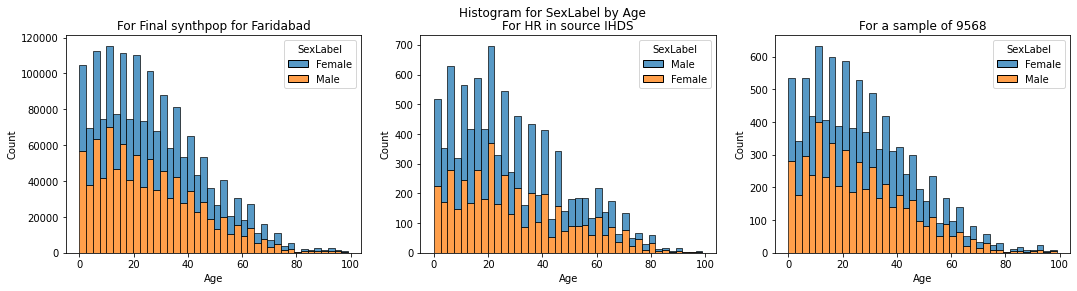

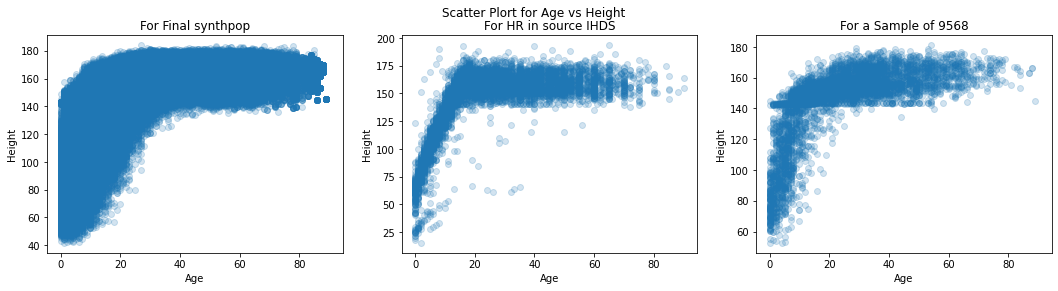

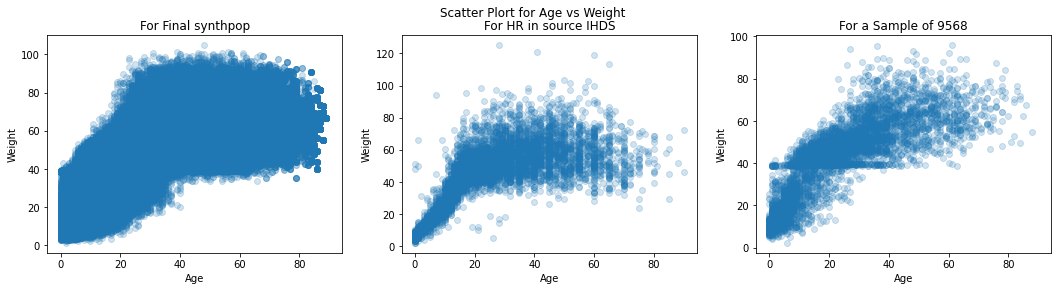

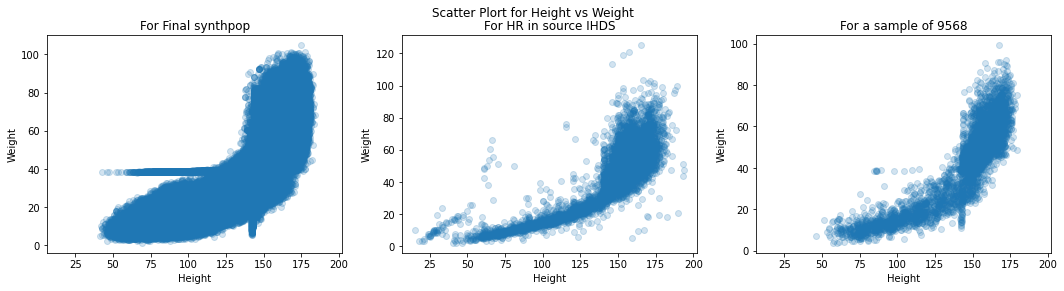

In [ ]:
all_plots()

In [ ]:
temp_name = name+'_'+'full_synthpop'
filename = "%s.csv" %temp_name
final.to_csv(filename)

# Save, load the model and generate new data
https://sdv.dev/SDV/user_guides/single_table/ctgan.html#save-and-share-the-model

# Test code
Add height weight columns to synthpop

In [ ]:
# hr_ihds_age_sexlabel_count = hr_ihds.groupby( [ "Age", "SexLabel"] ).size().to_frame(name = 'count').reset_index()
# hr_ihds_age_sexlabel_count.to_csv("HR_IHDS_Age_Gender_Count.csv")

In [ ]:
# def side_by_side(*objs, **kwds):
#     ''' A function to print objects side by side '''
#     from pandas.io.formats.printing import adjoin
#     space = kwds.get('space', 4)
#     reprs = [repr(obj).split('\n') for obj in objs]
#     print(adjoin(space, *reprs))

In [ ]:
# side_by_side(ipu_synthpop_age_sexlabel_req, preset_4_age_sexlabel_count)

In [ ]:
# model.fit(hr_ihds)

# Speedup- with TabularPreset took less than a second on an input of 6133 rows, 18 colmns
# Takes around 2 minutes to train on an input of 6133 rows, 18 colmns
# ConvergenceWarning - safe to ignore source: https://github.com/sdv-dev/SDGym/issues/44

In [ ]:
# model.get_metadata()

#'TabularPreset' does not have 'get_metadata'
# works with other models of sdv

# Test code

Merge base pop and additional columns 

1. Get required no of rows from sdv's model, for all combinations of age and sexlabel
2. Make a dataframe
3. Merge with IPU

In [ ]:
# sample_count = ipu_synthpop_age_sexlabel_req.loc[(ipu_synthpop_age_sexlabel_req['Age'] == 0) & (ipu_synthpop_age_sexlabel_req['SexLabel'] == 'Female')]
# type(sample_count['count'])
# count = int(sample_count['count'])
# count
# preset_data_to_append[(preset_data_to_append['Age'] == 0) & (preset_data_to_append['SexLabel'] == 'Female')].sample(n=count)

# Conditioned Sampling not working, seems like an issue with the sdv's codebase, reported the issue on Github on sdv repo

In [ ]:
# from sdv.sampling.tabular import Condition

# # f_0 = Condition(column_values={'SexLabel': 'Female', 'Age': 0}, num_rows=16110)
# # m_0 = Condition(column_values={'SexLabel': 'Male', 'Age': 0}, num_rows=18895)

# f_0 = Condition({'SexLabel' : 'Female', 'Age': 0}, num_rows=100)

# all_conditions = [f_0]

In [ ]:
# model.sample_conditions(conditions=all_conditions)

In [ ]:
# df = pd.DataFrame(columns=list("ABC"))
# df.loc[len(df)] = [1,2,3]
# count = 0

# data_req = data_req.reset_index()  # make sure indexes pair with number of rows
# for index, row in data_req.iterrows():
#     condition = Condition({
#     'SexLabel': row['SexLabel'],
#     'Age': row['Age']
#     }, num_rows=row['count'])
#     print(row['Age'], row['SexLabel'], row['count'])
#     append_cols = append_cols.append(model.sample_conditions(conditions=[condition],max_tries=100, batch_size_per_try=20000))
#     count = count + 1
#     if (count == 20):
#         break
    

In [ ]:
# condition = Condition({
#     'SexLabel': 'Female',
#     'Age': 0
#     }, num_rows=2)

# Following comparison does not make much sense- compare with census data 

<AxesSubplot:title={'center':'For a Sample of 10k '}, xlabel='SexLabel', ylabel='Count'>

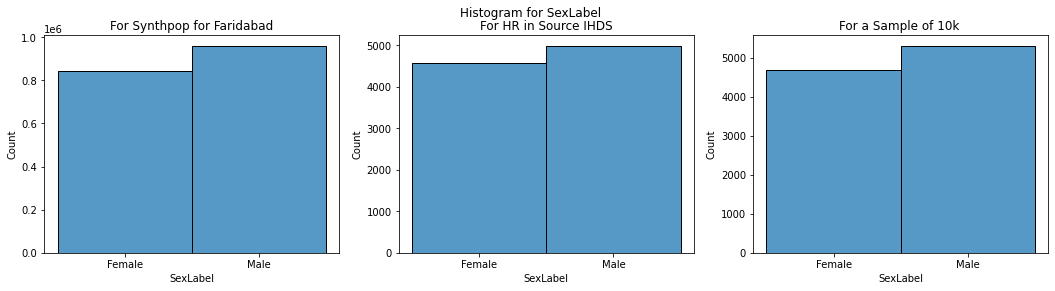

In [ ]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(18,4))

figure.suptitle('Histogram for SexLabel')

axes[0].set_title('For Synthpop for Faridabad')
axes[1].set_title('For HR in Source IHDS')
axes[2].set_title('For a Sample of 10k ')

sns.histplot(ax=axes[0],data=final , x="SexLabel")
sns.histplot(ax=axes[1],data=hr_ihds , x="SexLabel")
sns.histplot(ax=axes[2],data=final.sample(n=10000) , x="SexLabel")

# Others

In [ ]:
final.groupby(['Age', 'SexLabel']).agg({'Age': ['count']})